In [1]:
import pandas as pd
from trino.dbapi import connect
from matplotlib import pyplot as plt

In [2]:
host = '10.138.0.24'
port = "8080"
user = 'ws-async@stable-hydra-400302.iam.gserviceaccount.com'
catalog="hyperlake"
schema="hyperdata"

conn = connect(
    host=host,
    port=port,
    user=user,
    catalog=catalog,
    schema=schema,
)
cur = conn.cursor()

In [12]:
cur.execute("""
WITH Transfers AS (
  SELECT token_address token, to_address account, 0 _out, CAST(value as DOUBLE) _in
  FROM "hyperlake"."ethereum"."token_transfers" 
  WHERE block_timestamp >= DATE_TRUNC('DAY', TIMESTAMP '2023-01-01 19:15:36') 
  AND   block_timestamp <  DATE_TRUNC('DAY', TIMESTAMP '2023-01-31 19:15:36') 
  UNION ALL

  SELECT token_address token, from_address account, CAST(value as DOUBLE) _out, 0 _in
  FROM "hyperlake"."ethereum"."token_transfers" 
  WHERE block_timestamp >= DATE_TRUNC('DAY', TIMESTAMP '2023-01-01 19:15:36') 
  AND   block_timestamp <  DATE_TRUNC('DAY', TIMESTAMP '2023-01-31 19:15:36') 
)

SELECT label.name, balances.* FROM (
  SELECT account, (1.0*(SUM(_in) - SUM(_out)) / 1000000.0) as balance
  FROM Transfers INNER JOIN  hyperlake.demo.labels labels ON token = labels.address
  WHERE labels.name = 'USD Coin (USDC)' 
  GROUP BY account
  ORDER BY balance DESC
  LIMIT 20000
) balances

LEFT OUTER JOIN hyperlake.demo.labels label ON account = label.address

WHERE label.name <> ''
ORDER BY balances.balance DESC
    """)
rows = cur.fetchall()
    

In [13]:
df = pd.DataFrame(rows, columns=['name', 'account', 'balance'])

In [14]:
with pd.option_context('display.max_colwidth', None):
  display(df)

,name,account,balance
0,Null Address: 0x000...000,0x0000000000000000000000000000000000000000,1.999570e+09
1,Genesis Trading: OTC Desk,0xd628f7c481c7dd87f674870bec5d7a311fb1d9a2,2.037328e+08
2,Circle,0x55fe002aeff02f77364de339a1292923a15844b8,1.505247e+08
3,1inch: Team Investment Fund Collection,0x225d3822de44e58ee935440e0c0b829c4232086e,8.441932e+07
4,Curve.fi: DAI/USDC/USDT Pool,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,4.430828e+07
...,...,...,...
119,Sybil Delegate: acatlucky,0x9ac41e441131d8bad5f165c2a8dd71e5f7bfaea8,9.959684e+03
120,Sorbet Finance Hack Alert 93,0x8aa25ef2c43f0afc214ed7263b6abd189dc18594,9.580101e+03
121,Sorbet Finance Hack Alert 43,0x3d44f67b32454ebc1f579873edf480faa80cd953,8.041346e+03
122,SushiSwap: LINA-USDC,0x67e4423340b56c119749a570afa460f031ac29d6,7.002895e+03


In [22]:
# Define the list of exchanges to filter
exchanges = ['binance', 'circle', 'kraken', 'huobi', 'coinbase', 'kucoin', 'nexo', 'gemini', 'deribit', 'okx', 'crypto.com', 'hotbit', 'coinlist']

# Filter rows based on the exchange names
#df_filtered = df[df['name'].str.lower().str.split().str[0].isin(exchanges)]
df_filtered = df
# Extract the exchange name from the 'name' field and group by it
df_grouped = df_filtered.copy()
df_grouped['exchange'] = df_grouped['name'].str.lower().str.split().str[0]
df_grouped = df_grouped[df_grouped['exchange'] != 'null']

df_grouped = df_grouped.groupby('exchange')['balance'].sum().reset_index()
df_sorted = df_grouped.sort_values(by='balance', ascending=False).reset_index(drop=True)

display(df_sorted)

,exchange,balance
0,genesis,2.037328e+08
1,circle,1.505247e+08
2,1inch:,8.444044e+07
3,binance,5.062323e+07
4,curve.fi:,4.430828e+07
...,...,...
71,whg:,2.331500e+04
72,multichain:,1.643190e+04
73,coinhako,1.071543e+04
74,onebtc,1.056830e+04


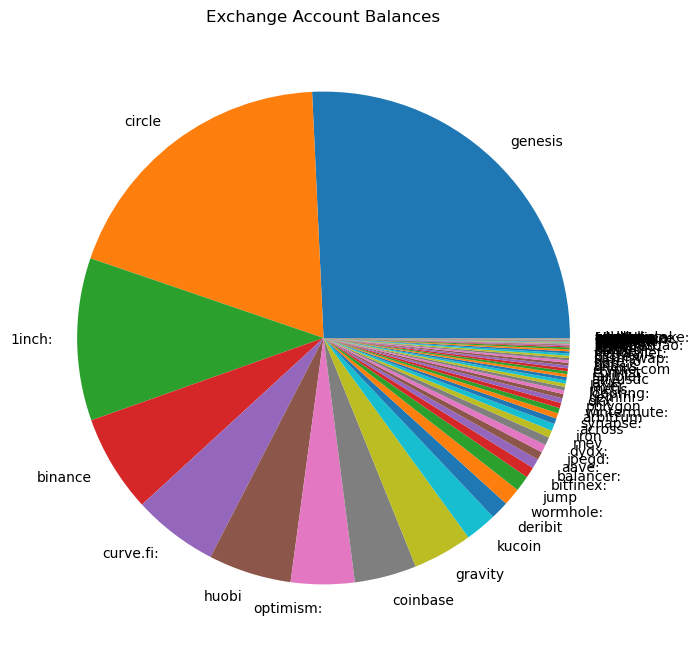

In [25]:
import matplotlib.pyplot as plt

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_sorted['balance'], labels=df_sorted['exchange'])
plt.title('Exchange Account Balances')
plt.show()


In [ ]:
!pip